In [1]:
import os
import copy
from collections import OrderedDict
from collections import defaultdict
import pickle

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 10

%matplotlib inline
np.random.seed(42)

import dtaidistance
from dtaidistance import dtw, clustering
from matplotlib.pyplot import figure

In [2]:
class DataTable: pass
all_table = joblib.load("prepared_data/all_data_with_na.jbl")
if not os.path.exists("images/clustering/"):
    os.makedirs("images/clustering/")
if not os.path.exists("algorithms"):
    os.makedirs("algorithms")

In [3]:
def prepare_tslearn_dataset(all_table):
    all_table.matrix = copy.deepcopy(all_table.matrix).dropna(axis=0, how='any')
    info = np.unique(all_table.matrix.CONTRACT_ID, return_counts=True)
    contracts = info[0]
    amounts = info[1]

    relevant = list()
    for contract_id, amount in zip(contracts, amounts):
        if amount >= 12:
            relevant.append(contract_id)
    matrix = all_table.matrix
    long_enough = matrix[matrix['CONTRACT_ID'].isin(relevant)]
    long_enough = long_enough[long_enough['PERIOD_ID'] <= 12]
    series_to_cluster = long_enough[['CONTRACT_ID', 'PERCENT_ACTUAL']]
    X_train = np.zeros(shape=(len(relevant), 12, 1), dtype=np.float32)
    index = 0
    for _, df in series_to_cluster.groupby('CONTRACT_ID'):
        series = df['PERCENT_ACTUAL']
        X_train[index, :, 0] = series
        index += 1
    return X_train

In [4]:
X_train = prepare_tslearn_dataset(all_table)
DTAI_train = np.array(X_train.reshape((-1, 12))).astype(np.float64)
DTAI_sample = DTAI_train[np.random.choice(DTAI_train.shape[0], 20, replace=False)]


# 1. Agglomerative Clustering

Agglomerative clustering is typically used to guess the number of clusters.

## 1.1. Hierarchical Tree

First fit on the full dataset, then make dendrogram for a subsample. Essentially, visualization allows to make a guess on 3-5 number of clusters. There is either flat repayments, or single spike, or big initially then flat, or flat and big in the end. 

The compiled dtaidistance C-OMP library is not available.
Use Python's multiprocessing library for parellelization (use_mp=True).
See the documentation for alternative installation options.
The compiled dtaidistance C-OMP library is not available.
Using the Python multiprocessing library instead (use_mp=True).
See the documentation for alternative installation options.

 98%|█████████▊| 853/868 [00:01<00:00, 466.84it/s]The compiled dtaidistance C-OMP library is not available.
Use Python's multiprocessing library for parellelization (use_mp=True).
See the documentation for alternative installation options.
The compiled dtaidistance C-OMP library is not available.
Using the Python multiprocessing library instead (use_mp=True).
See the documentation for alternative installation options.


 95%|█████████▌| 19/20 [00:00<00:00, 5923.28it/s]


(None,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ad634e430>,
       dtype=object))

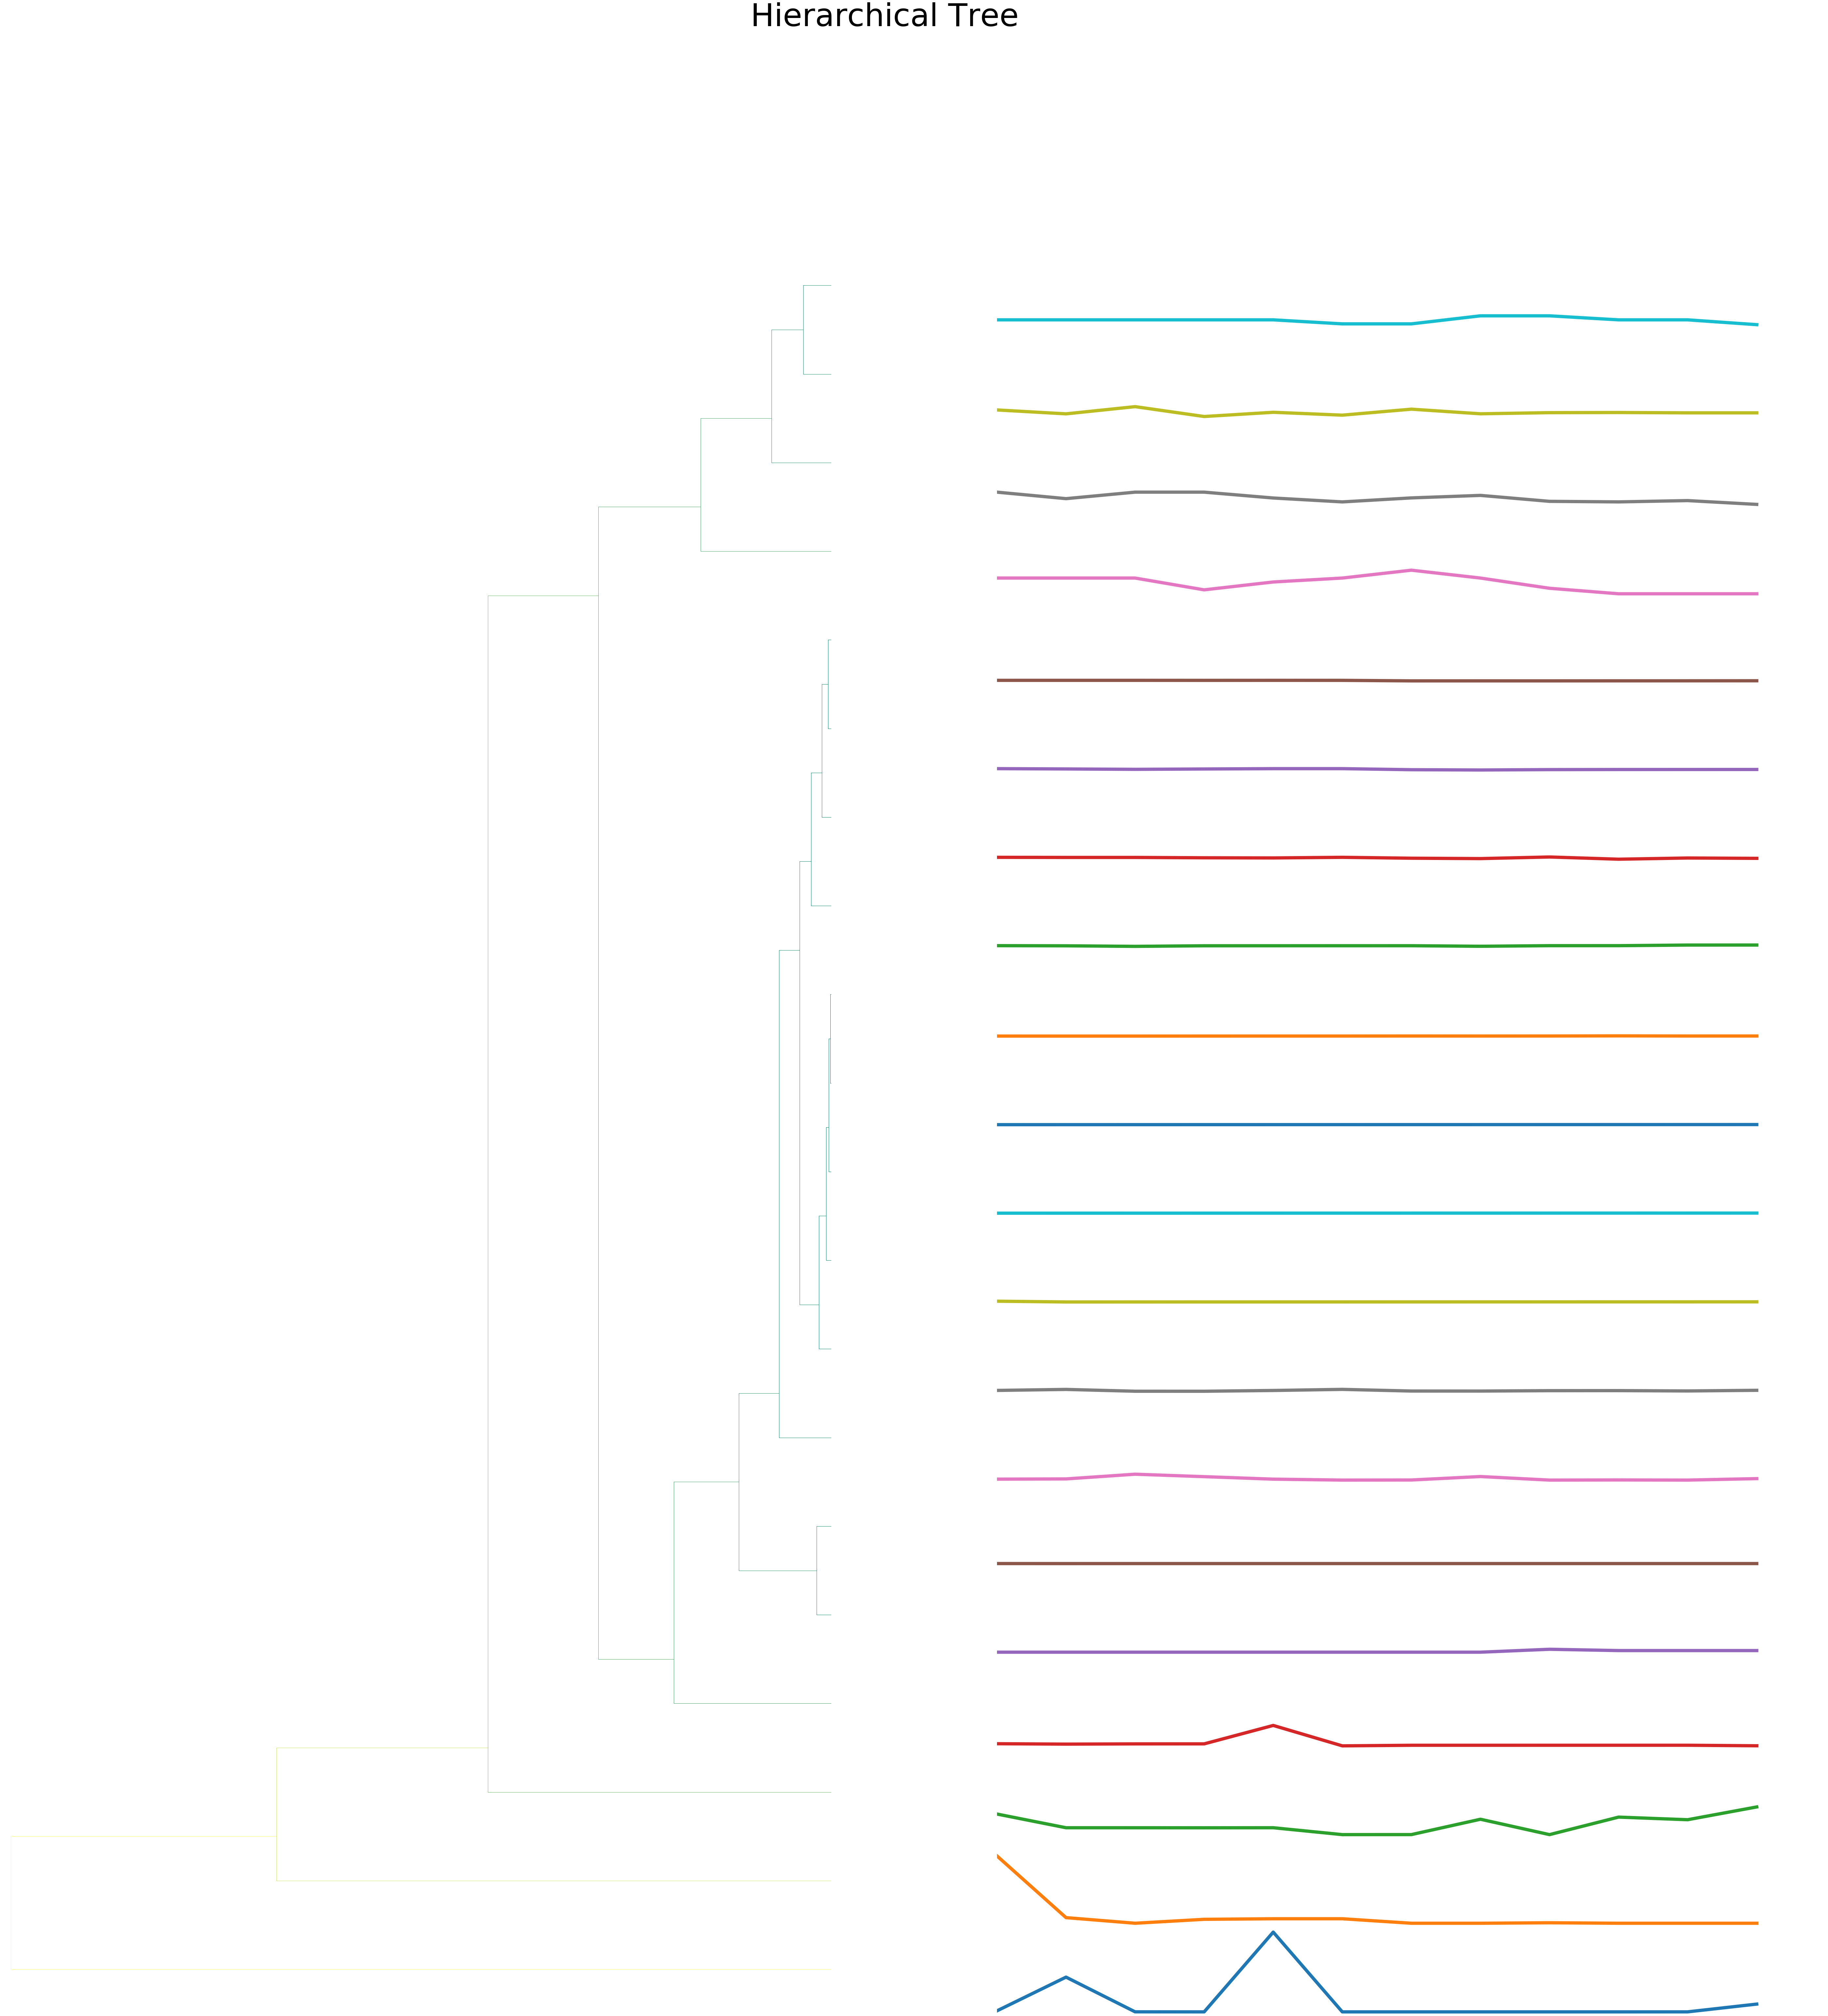

In [5]:
matplotlib.rcParams['lines.linewidth'] = 10
hierarchical_model = clustering.Hierarchical(dtw.distance_matrix_fast, {})
cluster_idx = hierarchical_model.fit(DTAI_train)
hierarchical_tree = clustering.HierarchicalTree(hierarchical_model)
cluster_idx = hierarchical_tree.fit(DTAI_sample)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100))
fig.suptitle("Hierarchical Tree", fontsize=96)
hierarchical_tree.plot("images/clustering/hierarchical_tree.png", axes=ax, ts_height=100, cmap='summer')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100))
fig.suptitle("Hierarchical Tree", fontsize=96)
hierarchical_tree.plot(axes=ax, ts_height=100, cmap='summer')

## 1.2. Linkage Tree

After fitting the linkage tree, hypothesis stays the same.

The compiled dtaidistance C-OMP library is not available.
Use Python's multiprocessing library for parellelization (use_mp=True).
See the documentation for alternative installation options.
The compiled dtaidistance C-OMP library is not available.
Using the Python multiprocessing library instead (use_mp=True).
See the documentation for alternative installation options.



(None,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ada7d6d00>,
       dtype=object))

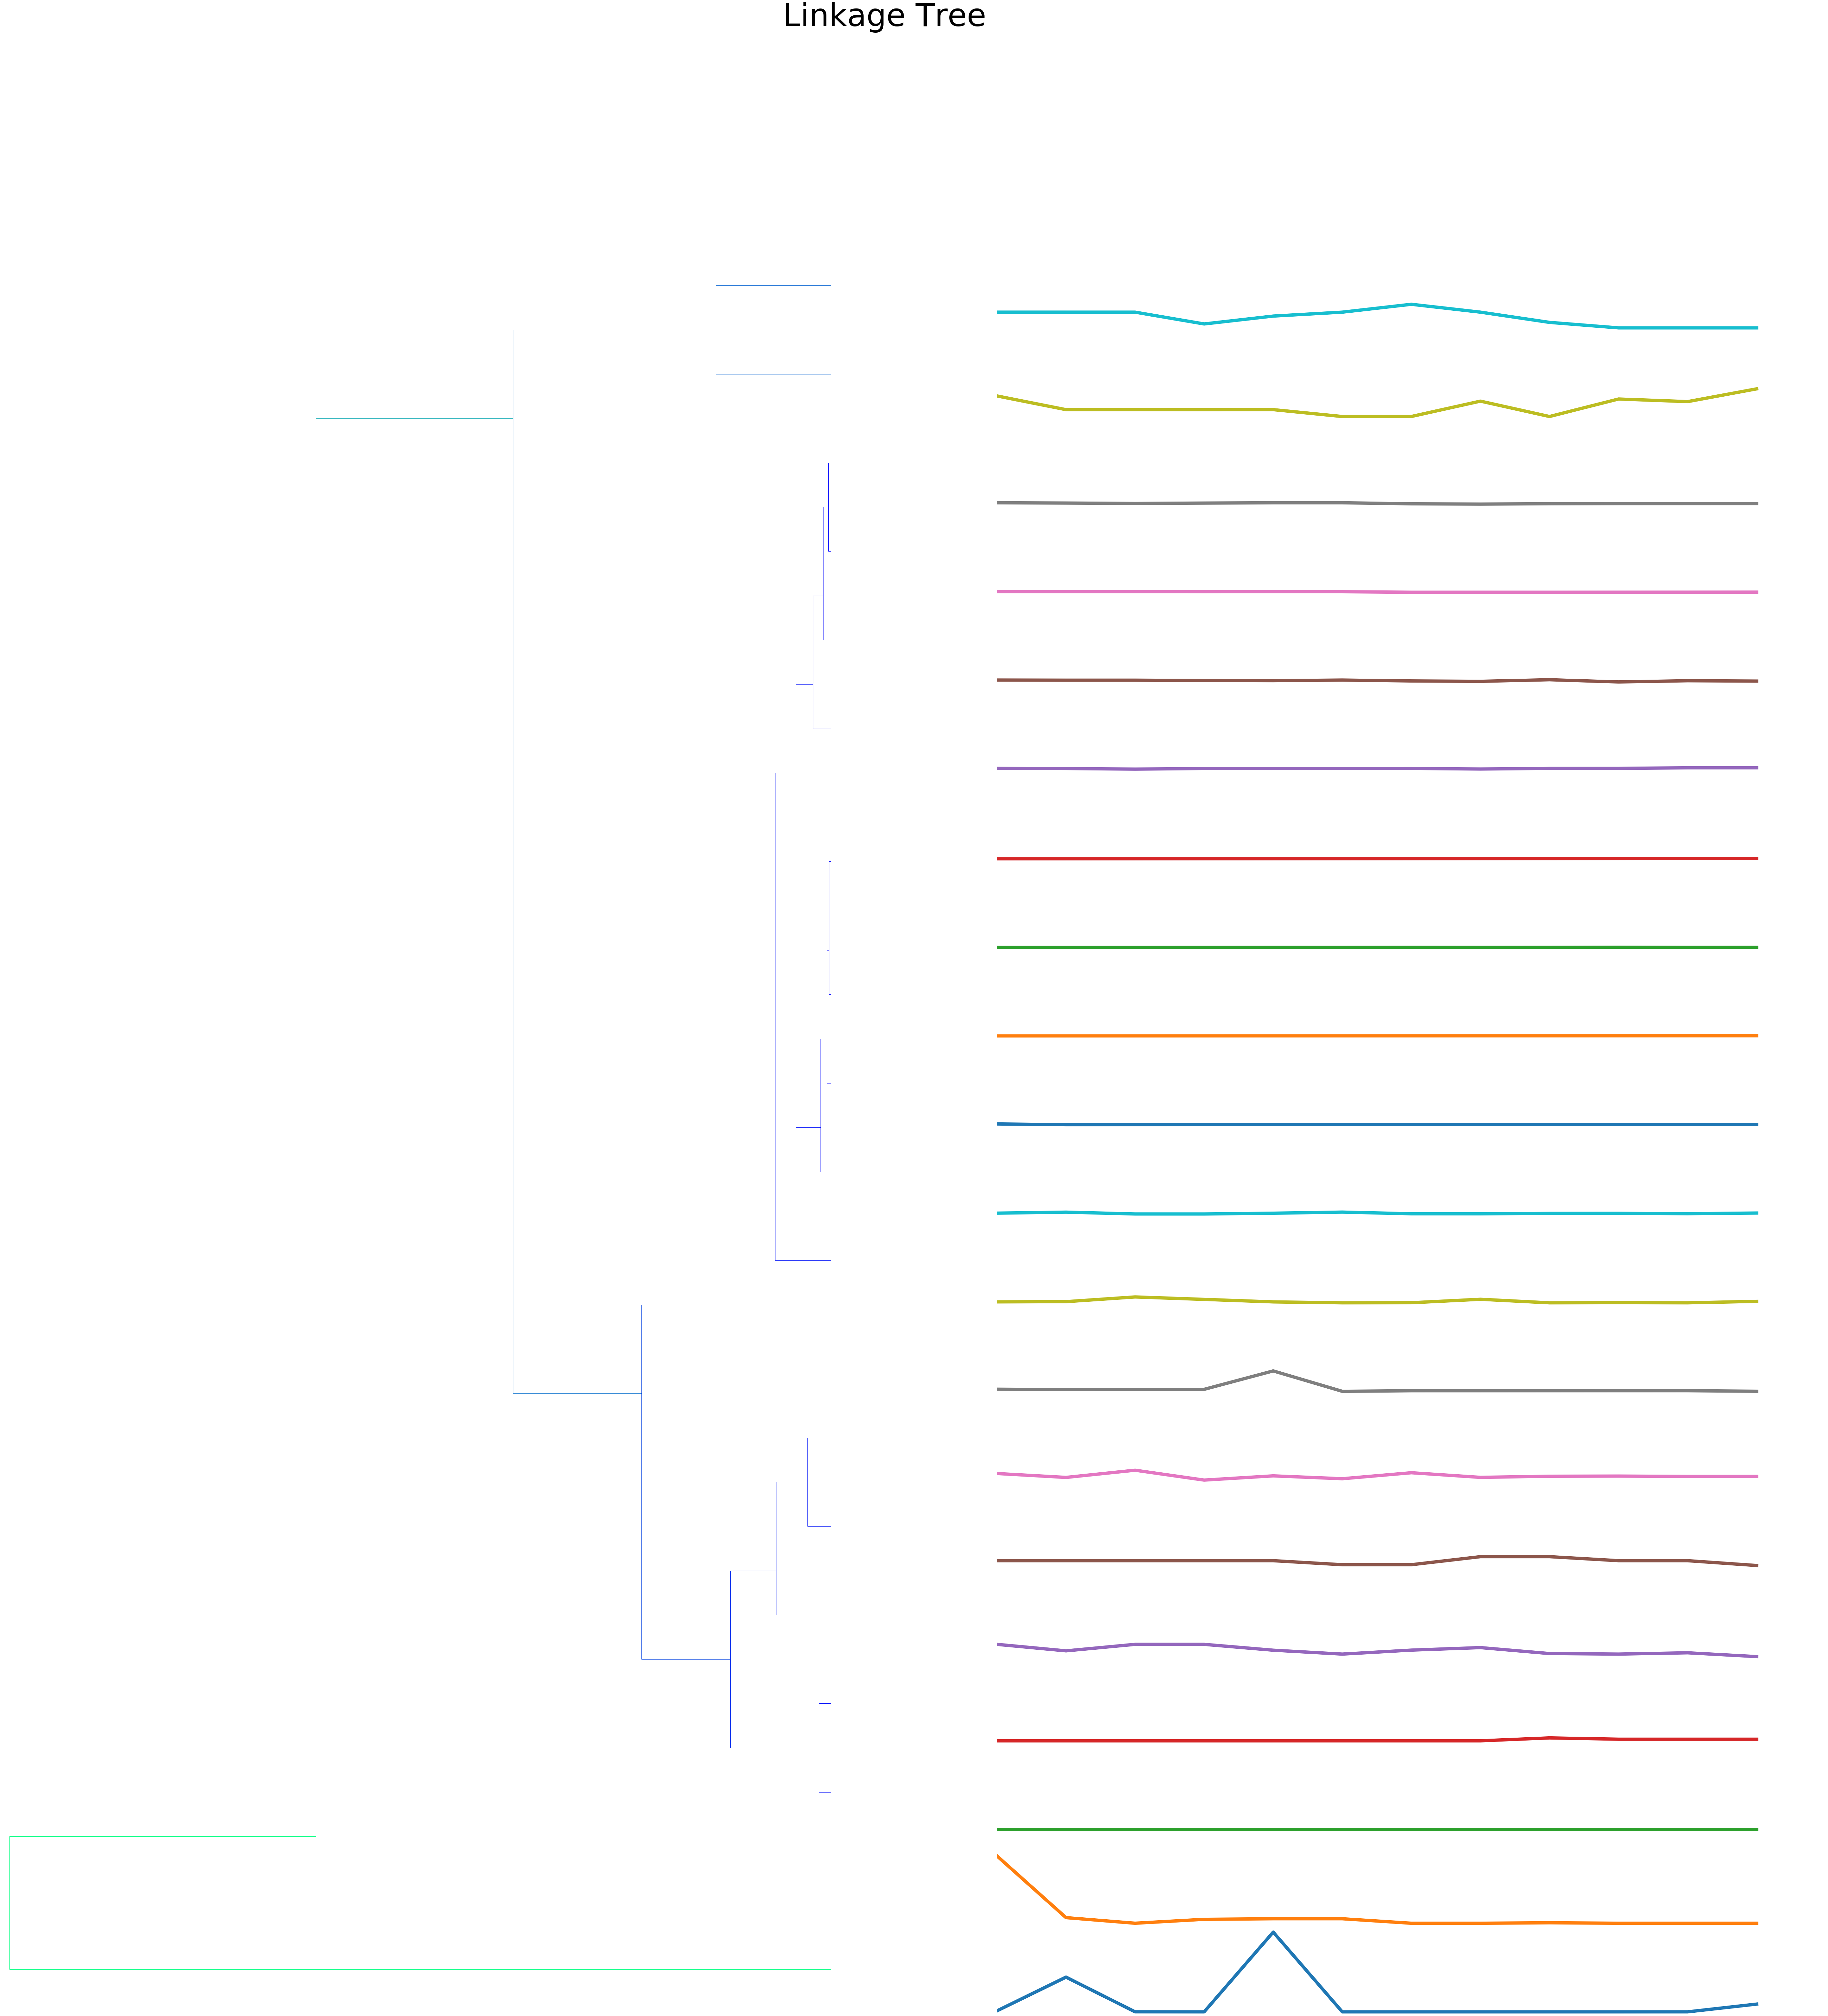

In [6]:
matplotlib.rcParams['lines.linewidth'] = 10
linkage_tree = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = linkage_tree.fit(DTAI_sample)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100))
fig.suptitle("Linkage Tree", fontsize=96)
linkage_tree.plot("images/clustering/linkage_tree.png", axes=ax, ts_height=100, cmap='winter')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100))
fig.suptitle("Linkage Tree", fontsize=96)
linkage_tree.plot(axes=ax, ts_height=100, cmap='winter')

## 1.3. k-Medoids

k-Medoids find three types of clusters: gradually decreasing, flat repayment ans spiked repayment.

The compiled dtaidistance C-OMP library is not available.
Use Python's multiprocessing library for parellelization (use_mp=True).
See the documentation for alternative installation options.
The compiled dtaidistance C-OMP library is not available.
Using the Python multiprocessing library instead (use_mp=True).
See the documentation for alternative installation options.



(None,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8adaaa2250>,
       dtype=object))

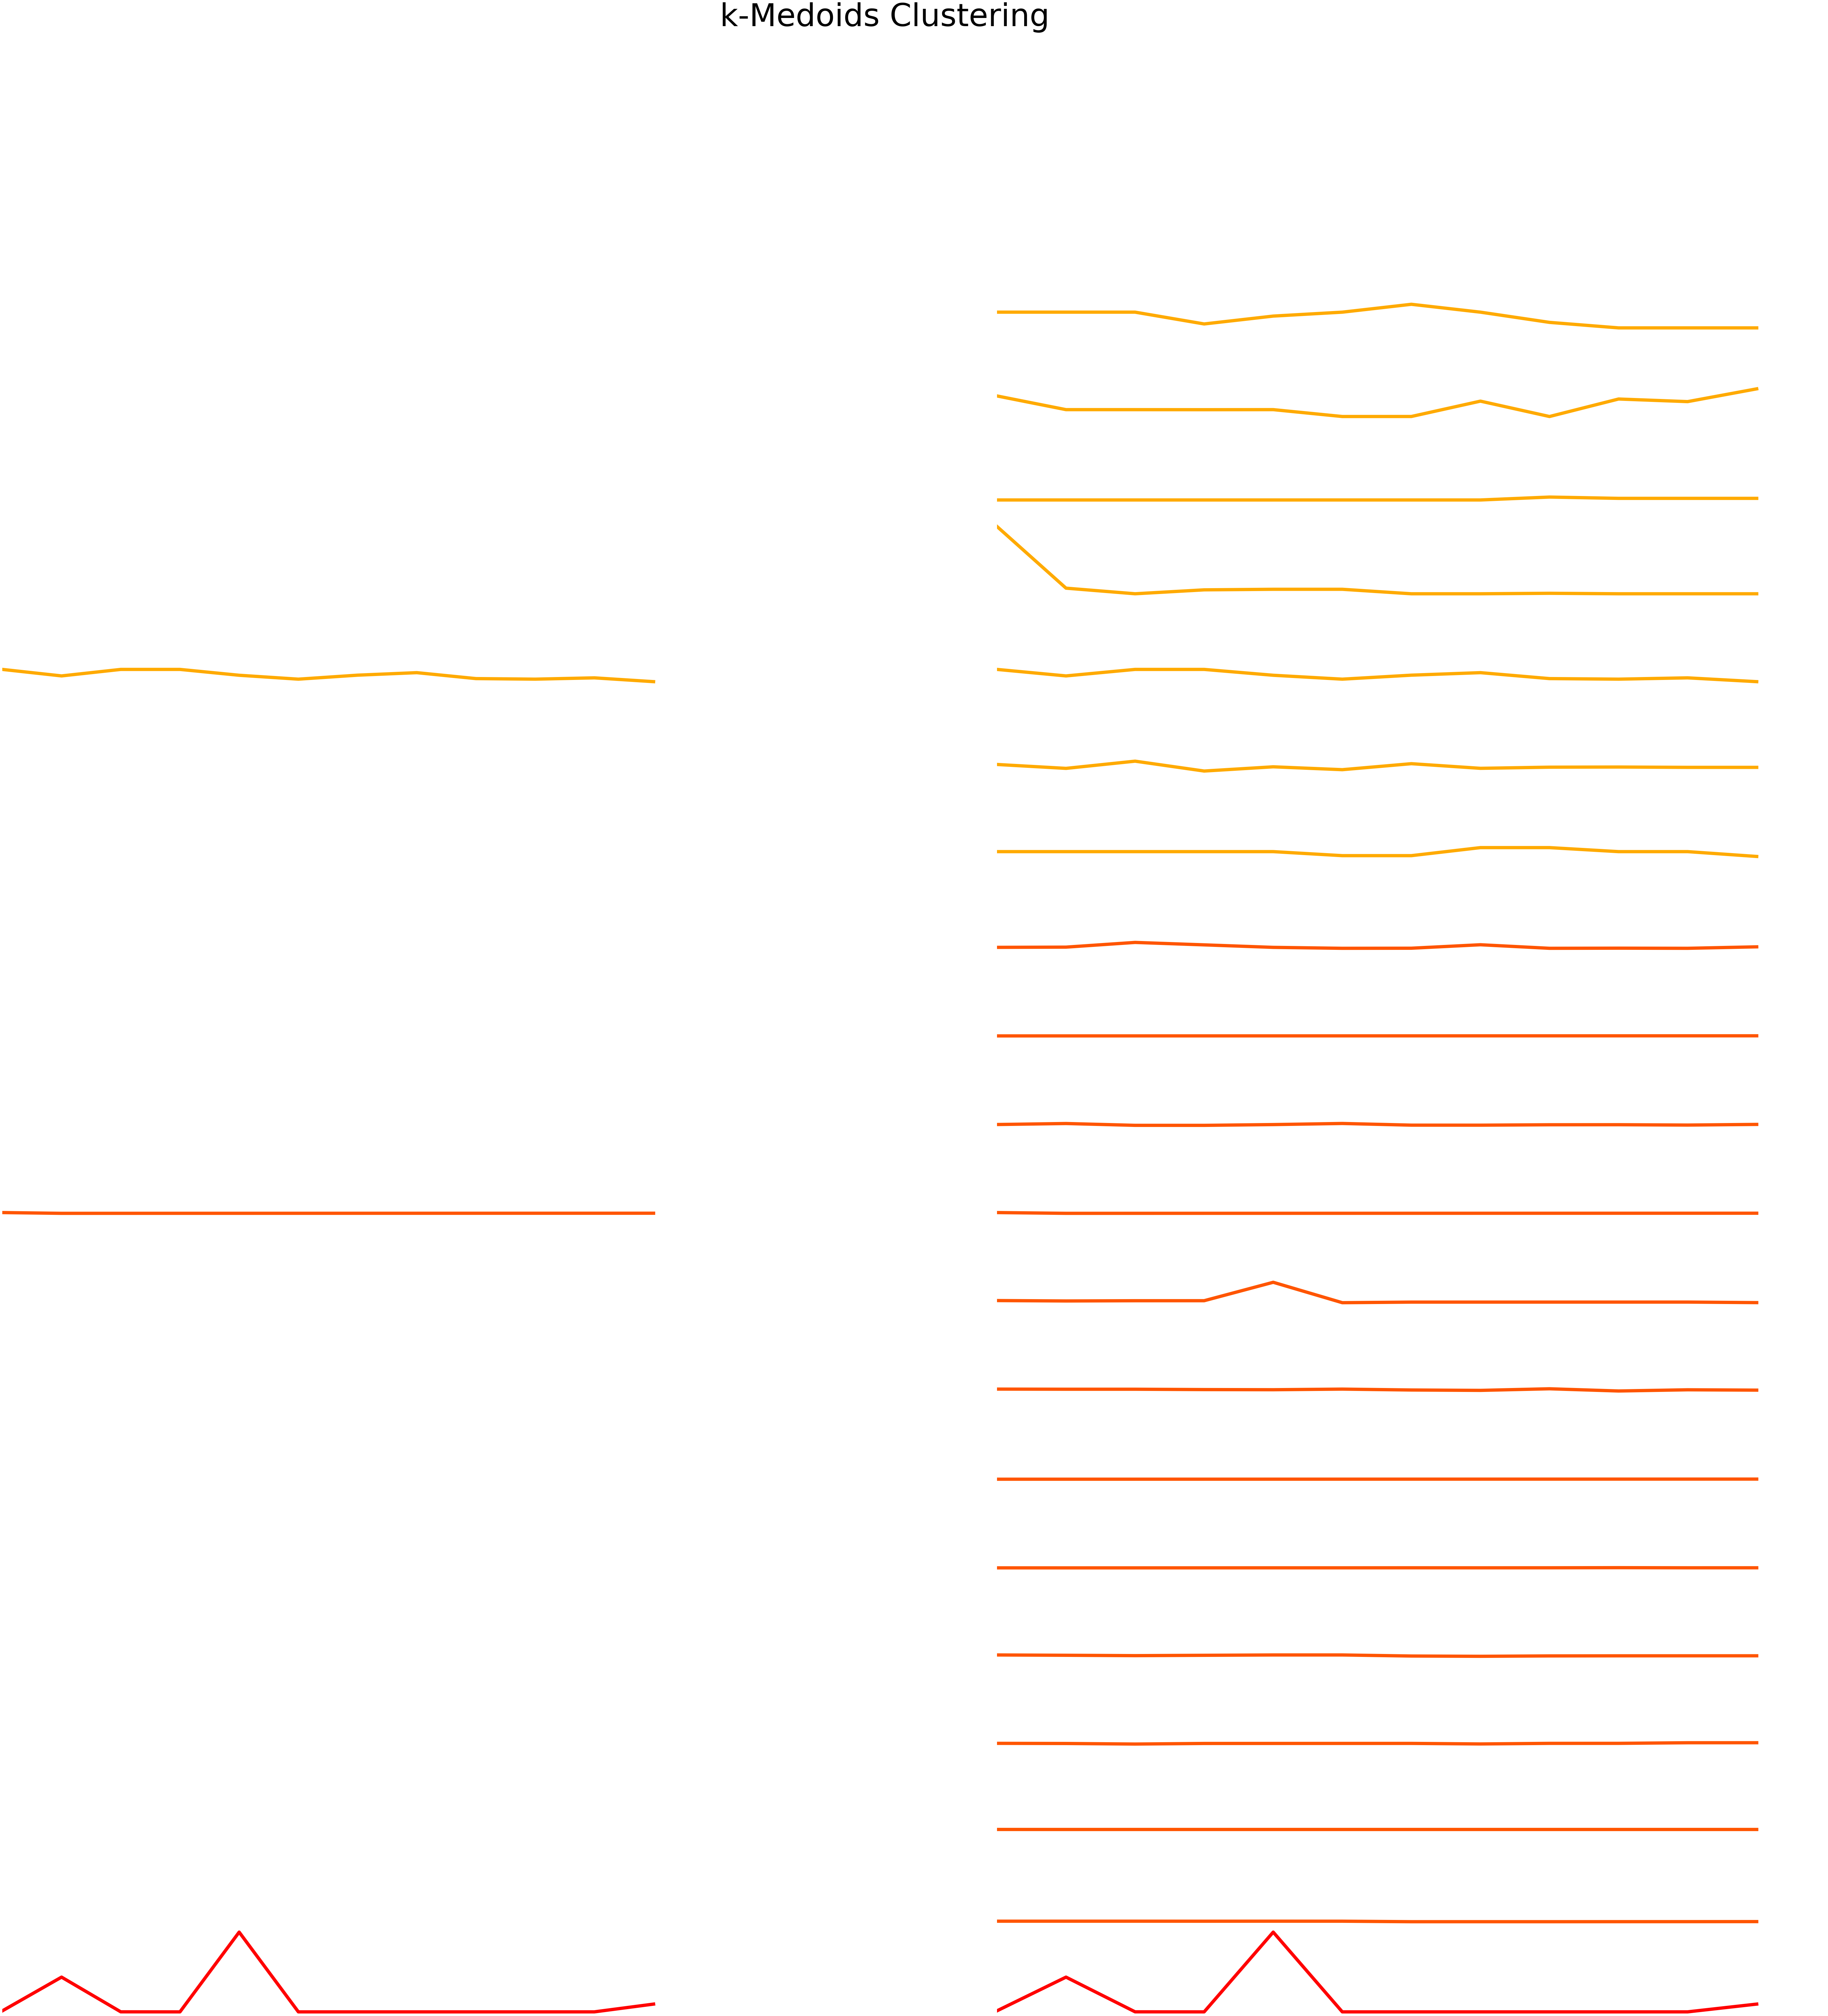

In [7]:
matplotlib.rcParams['lines.linewidth'] = 10
medoids = clustering.KMedoids(dtw.distance_matrix_fast, {}, k=3)
cluster_idx = medoids.fit(DTAI_sample)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100))
fig.suptitle("k-Medoids Clustering", fontsize=96)
medoids.plot('images/clustering/kmedoids.png', axes=ax, ts_height=100, cmap='autumn')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(100, 100))
fig.suptitle("k-Medoids Clustering", fontsize=96)
medoids.plot(axes=ax, ts_height=100, cmap='autumn')

# 2. Tslearn Clustering


In [8]:
from tslearn.barycenters import dtw_barycenter_averaging

def visualize_clustering(X_train, title, algorithm, labels, n_clusters, filename):
    YEAR_SIZE = 12
    plt.figure(figsize=(20,10))
    fig = plt.gcf()
    fig.suptitle(title, fontsize=14)
    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, yi + 1)
        for xx in X_train[y_pred == yi]:
            plt.plot(list(range(1, YEAR_SIZE + 1)), xx.ravel(), "k-", alpha=.2)
        if hasattr(algorithm, 'cluster_centers_'):
            plt.plot(list(range(1, YEAR_SIZE + 1)), algorithm.cluster_centers_[yi].ravel(), "r-")
        else:
            barycenter = dtw_barycenter_averaging(X_train[y_pred==yi], max_iter=50, tol=1e-3)
            plt.plot(list(range(1, YEAR_SIZE + 1)), barycenter.ravel(), "r-")
        plt.xlim(1, YEAR_SIZE)
        
    plt.savefig(filename, dpi=300, bbox_inches='tight')

In [9]:
def print_clustering_report(clusters):
    info = np.unique(clusters, return_counts=True)
    for idx, count in zip(info[0], info[1]):
        print("Cluster:", idx + 1, "Size:", count)


In [10]:
def make_clustering_barplot(clusters, title, save_path):
    info = np.unique(clusters, return_counts=True)
    cluster_df = pd.DataFrame()
    cluster_df['Clusters'] = info[0] + 1
    cluster_df['Sizes'] = info[1]
    sns.barplot('Clusters', 'Sizes', data=cluster_df)
    plt.title(title)
    plt.savefig(save_path)

## 2.1. DTW clustering

By hand-based tuning, four patterns look the most realistic:
- Flat repayment
- Spiked repayment (flat, then fixing almost all dept, and then flatly concluding)
- Flat and high payment at the end.
- High payment initially and flat repayment to the end.

In [11]:
matplotlib.rcParams['lines.linewidth'] = 2.5
from tslearn.clustering import TimeSeriesKMeans
N_CLUSTERS = 4
dtw_km = TimeSeriesKMeans(n_clusters=N_CLUSTERS, n_init=3, metric="dtw", verbose=False,
                          n_jobs=-1, max_iter_barycenter=10, random_state=42)
y_pred = dtw_km.fit_predict(X_train)
joblib.dump(dtw_km, 'algorithms/dtw_km.alg')

['algorithms/dtw_km.alg']

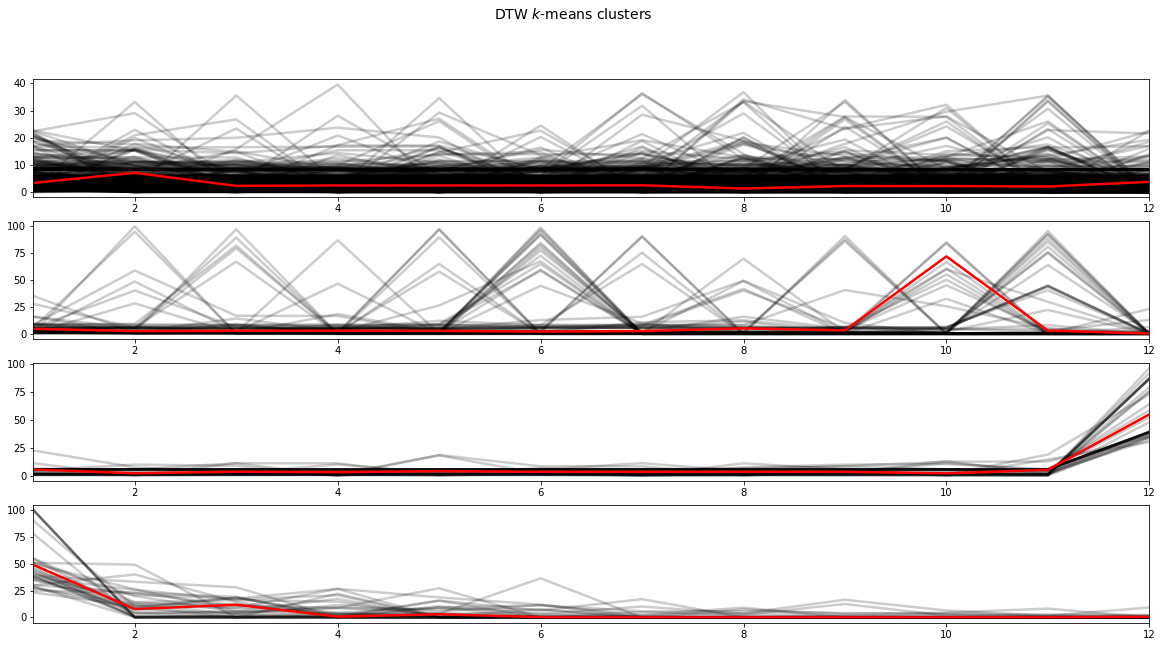

In [12]:
visualize_clustering(X_train, "DTW $k$-means clusters", dtw_km, y_pred, 
                     N_CLUSTERS, 'images/clustering/dtw_k_means_clusters.png')

Cluster: 1 Size: 734
Cluster: 2 Size: 67
Cluster: 3 Size: 36
Cluster: 4 Size: 31


/home/nekrald/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


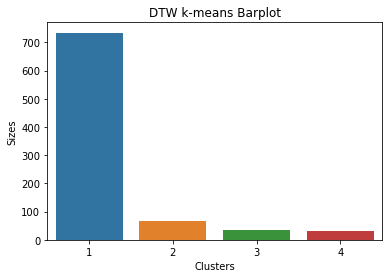

In [13]:
print_clustering_report(y_pred)
make_clustering_barplot(y_pred, "DTW k-means Barplot", 'images/clustering/dtw_kmeans_barplot.png')

## 2.2. KShape clustering

kShape clusters does not look very effective, though spiked pattern is also present.

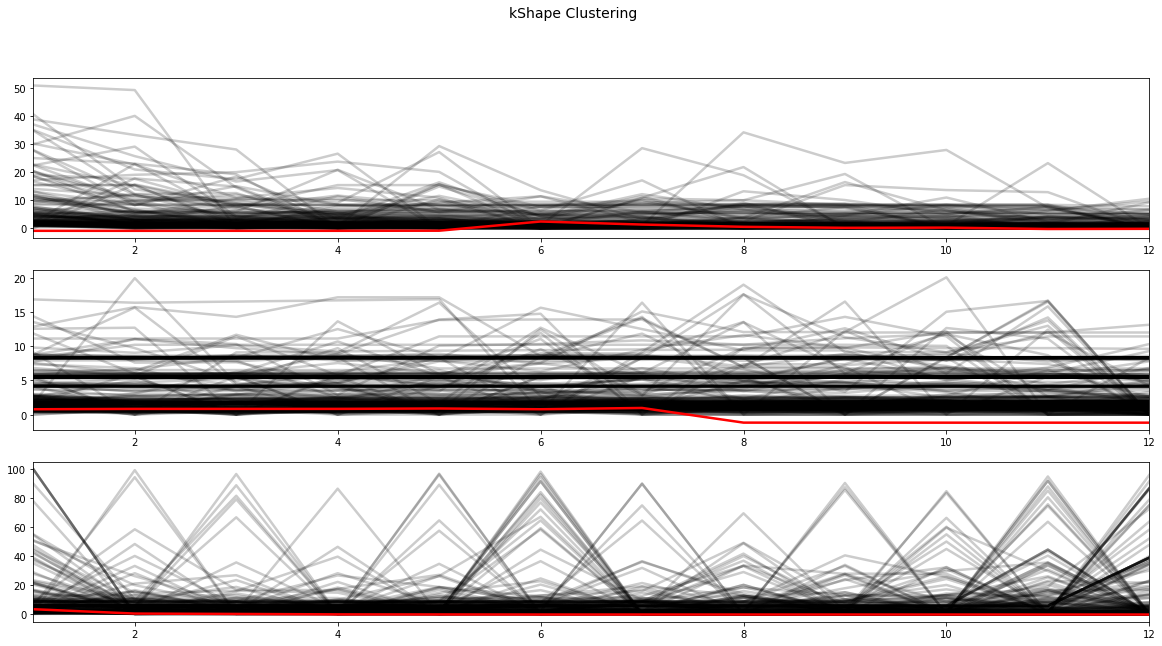

In [14]:
matplotlib.rcParams['lines.linewidth'] = 2.5
from tslearn.clustering import KShape
N_CLUSTERS = 3
ks = KShape(n_clusters=N_CLUSTERS, verbose=False, random_state=42, n_init=15, tol=1e-7, max_iter=200)
y_pred = ks.fit_predict(X_train)
visualize_clustering(X_train, "kShape Clustering", ks, y_pred, 
                     N_CLUSTERS, "images/clustering/kshape_clusters.png")

Cluster: 1 Size: 166
Cluster: 2 Size: 450
Cluster: 3 Size: 252


/home/nekrald/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


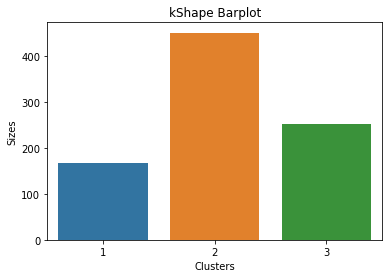

In [15]:
print_clustering_report(y_pred)
make_clustering_barplot(y_pred, "kShape Barplot", 'images/clustering/kshape_barplot.png')

## 2.3. Kernel kMeans

Kernel kMeans have found spiked pattern, big initially then flat, and flat then big in the end.

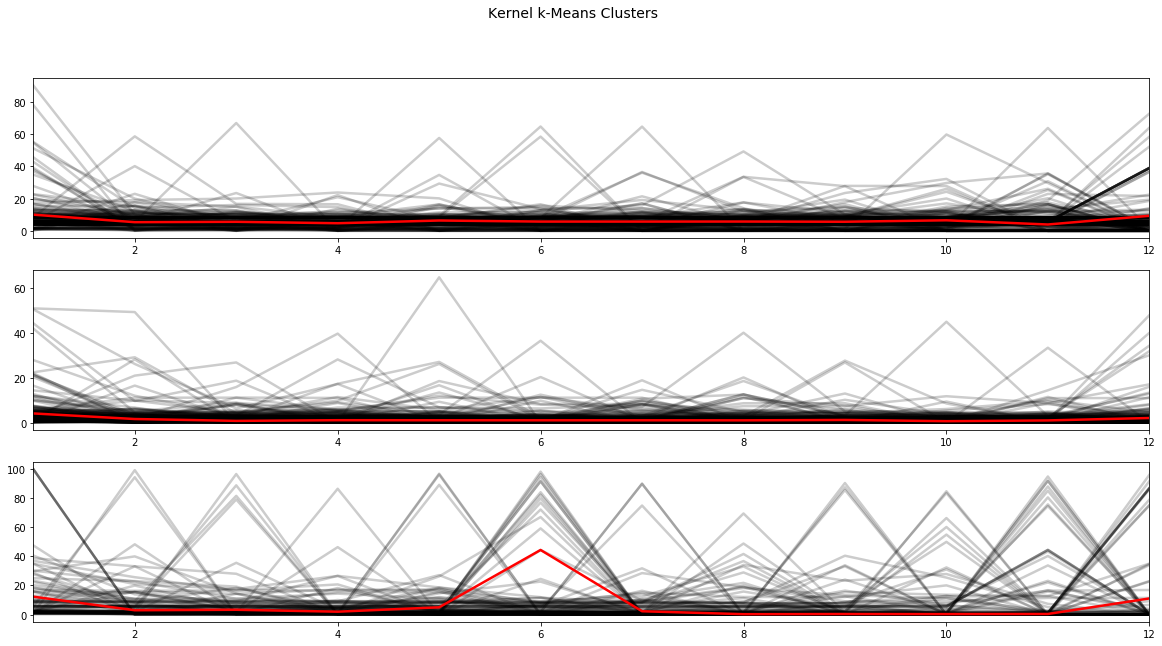

In [16]:
matplotlib.rcParams['lines.linewidth'] = 2.5
from tslearn.clustering import KernelKMeans
N_CLUSTERS = 3
gak_km = KernelKMeans(n_clusters=N_CLUSTERS, kernel="gak", kernel_params={"sigma": "auto"},
                      n_init=5, verbose=False, n_jobs=-1, random_state=42)
y_pred = gak_km.fit_predict(X_train)
visualize_clustering(X_train, "Kernel k-Means Clusters", gak_km, y_pred, 
                     N_CLUSTERS, "images/clustering/kernel_kmeans_clusters.png")

Cluster: 1 Size: 274
Cluster: 2 Size: 485
Cluster: 3 Size: 109


/home/nekrald/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


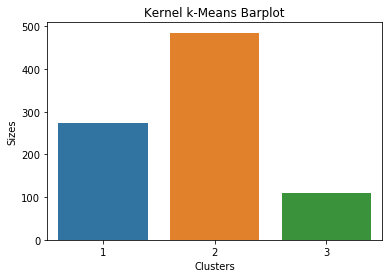

In [17]:
print_clustering_report(y_pred)
make_clustering_barplot(y_pred, "Kernel k-Means Barplot", 'images/clustering/kernel_kmeans_barplot.png')